# 使用MindSpore构造并训练VGG网络

## 下载数据集

In [1]:
# 使用download 来下载 CIFAR-10 数据集
# !pip install download
from download import download
url = "http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"
download(url, "./datasets-cifar10-bin", kind="tar.gz")

## 训练和测试数据集的构建

In [1]:
import mindspore as ms
import numpy as np
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore import nn, ops

# ms.set_context(mode=ms.GRAPH_MODE, device_target='Ascend')

data_dir = "./datasets-cifar10-bin/cifar-10-batches-bin" # 数据集根目录
batch_size = 64 # 批量大小
image_size = 32 # 训练图像空间大小
workers = 8 # 并行线程个数
num_classes = 10 # 分类数量



batch_size,image_size,workers,num_classes

(64, 32, 8, 10)

## 利用mindspore.dataset中的函数Cifar10Dataset对CIFAR-10数据集进行处理

In [2]:
def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):
    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []#需要做的变化的集合
    """
    对于训练集，首先进行随机裁剪和随机翻转的操作。
    使用mindspore.dataset.vision.RandomCrop对输入图像进行随机区域的裁剪,大小为(32, 32)。(4, 4, 4, 4)表示在裁剪前，将在图像上下左右各填充4个像素的空白。
    使用mindspore.dataset.RandomHorizontalFlip,对输入图像按50%的概率进行水平随机翻转
    """
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    """
    对数据集进行大小、规模的重组，以及归一化（帮助模型收敛）
    """
    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    #对于label进行的操作
    target_trans = [(lambda x: np.array([x]).astype(np.int32)[0])]

    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)

    data_set = data_set.map(
        operations=target_trans,
        input_columns='label',
        num_parallel_workers=workers)

    # 批量操作
    data_set = data_set.batch(batch_size)


    return data_set

In [3]:
# 利用上面写好的那个函数，获取处理后的训练与测试数据集
dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()
index_label_dict = dataset_train.get_class_indexing()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()

step_size_val,step_size_train,index_label_dict,dataset_train

(157,
 782,
 {},
 <mindspore.dataset.engine.datasets.BatchDataset at 0xffff54789ad0>)

Image shape: (64, 3, 32, 32), Label: [5 1 9 3 8 0 4 5 2 4 7 3 6 6 5 7 9 2 0 9 7 1 5 7 6 0 9 2 1 1 8 9 5 3 4 6 4
 9 4 1 1 1 4 7 3 2 7 6 0 0 7 3 0 6 5 7 7 3 3 2 3 6 3 4]


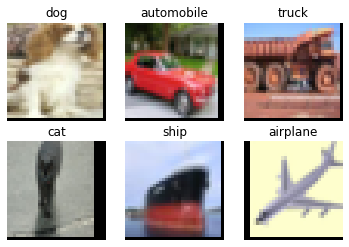

In [4]:
import matplotlib.pyplot as plt
import numpy as np

data_iter = next(dataset_train.create_dict_iterator())

images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()
print(f"Image shape: {images.shape}, Label: {labels}")

classes = []

with open(data_dir+"/batches.meta.txt", "r") as f:
    for line in f:
        line = line.rstrip()
        if line != '':
            classes.append(line)

plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"{classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
#展示训练集的数据（标签与原图）
plt.show()

In [5]:
class VGG16(nn.Cell):
    def __init__(self):
        super().__init__()
        numClasses = 10
        self.all_sequential = nn.SequentialCell(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1, pad_mode="pad"),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # 原始模型vgg16输入image大小是224*224，这里使用的数据集输入大小为32*32，缩小7倍
            # 可以根据需要的大小来调整，比如如果输入的image大小是224*224，那么由于224/32=7，因此就把第一个nn.Dense的参数改成512*7*7，其他不变
            nn.Flatten(),
            nn.Dense(512*1*1, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Dense(256, 256),
            nn.ReLU(),
            nn.Dropout(),
            nn.Dense(256, numClasses),
        )

    def construct(self, x):
        x = self.all_sequential(x)
        return x

In [6]:
from mindspore import load_checkpoint, load_param_into_net
def _vgg16(pretrained: bool = False):
    model = VGG16()
    "VGG16模型"
    #预训练模型的下载网址
    model_url = "https://download.mindspore.cn/model_zoo/official/cv/vgg/vgg16_ascend_0.5.0_cifar10_official_classification_20200715/vgg16.ckpt"
    #存储路径
    model_ckpt = "./LoadPretrainedModel/vgg16_0715.ckpt"

    if pretrained:
        download(url=model_url, path=model_ckpt)
        param_dict = load_checkpoint(model_ckpt)
        load_param_into_net(model, param_dict)

    return model

Start Training Loop ...


[WARNING] DEVICE(20488,ffffb9a10780,python):2022-12-13-22:08:33.865.333 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/all_sequential-SequentialCell/50-Dropout/DropoutGenMask-op119] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(20488,ffffb9a10780,python):2022-12-13-22:08:33.865.622 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/all_sequential-SequentialCell/47-Dropout/DropoutGenMask-op120] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(20488,ffffb9a10780,python):2022-12-13-22:08:52.065.720 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/GatherD-op363] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(20488,ffffb9a1078

Epoch: [  1/ 10], Steps: [  1/782], Train Loss: [2.304]
Epoch: [  1/ 10], Steps: [101/782], Train Loss: [2.075]
Epoch: [  1/ 10], Steps: [201/782], Train Loss: [1.940]
Epoch: [  1/ 10], Steps: [301/782], Train Loss: [1.905]
Epoch: [  1/ 10], Steps: [401/782], Train Loss: [1.917]
Epoch: [  1/ 10], Steps: [501/782], Train Loss: [1.823]
Epoch: [  1/ 10], Steps: [601/782], Train Loss: [2.074]
Epoch: [  1/ 10], Steps: [701/782], Train Loss: [1.850]


[WARNING] DEVICE(20488,ffffb9a10780,python):2022-12-13-22:09:51.934.607 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/all_sequential-SequentialCell/50-Dropout/DropoutGenMask-op1926] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(20488,ffffb9a10780,python):2022-12-13-22:09:51.934.811 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/all_sequential-SequentialCell/47-Dropout/DropoutGenMask-op1927] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(20488,ffffb9a10780,python):2022-12-13-22:10:02.501.398 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/GatherD-op2170] don't support int64, reduce precision from int64 to int32.
[WARNING] DEVICE(20488,ffffb9a1

Epoch: [  1/ 10], Steps: [782/782], Train Loss: [2.057]


[WARNING] DEVICE(20488,ffffb9a10780,python):2022-12-13-22:10:19.870.529 [mindspore/ccsrc/plugin/device/ascend/hal/device/kernel_select_ascend.cc:330] FilterRaisedOrReducePrecisionMatchedKernelInfo] Operator:[Default/network-WithEvalCell/_loss_fn-CrossEntropyLoss/GatherD-op3441] don't support int64, reduce precision from int64 to int32.


--------------------------------------------------
Epoch: [  1/ 10], Average Train Loss: [1.960], Accuracy: [0.199]
--------------------------------------------------
Epoch: [  2/ 10], Steps: [  1/782], Train Loss: [2.053]
Epoch: [  2/ 10], Steps: [101/782], Train Loss: [1.978]
Epoch: [  2/ 10], Steps: [201/782], Train Loss: [1.913]
Epoch: [  2/ 10], Steps: [301/782], Train Loss: [1.891]
Epoch: [  2/ 10], Steps: [401/782], Train Loss: [1.808]
Epoch: [  2/ 10], Steps: [501/782], Train Loss: [1.982]
Epoch: [  2/ 10], Steps: [601/782], Train Loss: [1.779]
Epoch: [  2/ 10], Steps: [701/782], Train Loss: [1.918]
Epoch: [  2/ 10], Steps: [782/782], Train Loss: [2.862]
--------------------------------------------------
Epoch: [  2/ 10], Average Train Loss: [1.848], Accuracy: [0.266]
--------------------------------------------------
Epoch: [  3/ 10], Steps: [  1/782], Train Loss: [1.787]
Epoch: [  3/ 10], Steps: [101/782], Train Loss: [1.707]
Epoch: [  3/ 10], Steps: [201/782], Train Loss: [2

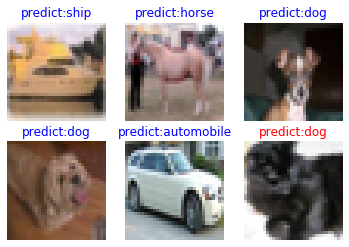

In [7]:
import mindspore as ms
# 定义VGG16网络，此处不采用预训练，即将pretrained设置为False
vgg16 = _vgg16(pretrained=False)

#param.requires_grad = True表示所有参数都需要求梯度进行更新。
for param in vgg16.get_parameters():
    param.requires_grad = True

# 设置训练的轮数和学习率，这里训练的轮数设置为40
num_epochs = 10
#基于余弦衰减函数计算学习率。学习率最小值为0.0001，最大值为0.0005，具体API见文档https://www.mindspore.cn/docs/zh-CN/master/api_python/nn/mindspore.nn.cosine_decay_lr.html?highlight=cosine_decay_lr
lr = nn.cosine_decay_lr(min_lr=0.0001, max_lr=0.0005, total_step=step_size_train * num_epochs,
                        step_per_epoch=step_size_train, decay_epoch=num_epochs)
# 定义优化器和损失函数
#Adam优化器，具体可参考论文https://arxiv.org/abs/1412.6980
opt = nn.Adam(params=vgg16.trainable_params(), learning_rate=lr)
# 交叉熵损失
loss_fn = nn.CrossEntropyLoss()

#前向传播，计算loss
def forward_fn(inputs, targets):
    logits = vgg16(inputs)
    loss = loss_fn(logits, targets)
    return loss

#计算梯度和loss
grad_fn = ops.value_and_grad(forward_fn, None, opt.parameters)

def train_step(inputs, targets):
    loss, grads = grad_fn(inputs, targets)
    opt(grads)
    return loss

# 实例化模型
model = ms.Model(vgg16, loss_fn, opt, metrics={"Accuracy": nn.Accuracy()})


# 创建迭代器
data_loader_train = dataset_train.create_tuple_iterator(num_epochs=num_epochs)
data_loader_val = dataset_val.create_tuple_iterator(num_epochs=num_epochs)

# 最佳模型存储路径
best_acc = 0
best_ckpt_dir = "./BestCheckpoint"
best_ckpt_path = "./BestCheckpoint/vgg16-best.ckpt"

import os
import stat

# 开始循环训练
print("Start Training Loop ...")

for epoch in range(num_epochs):
    losses = []
    vgg16.set_train()

    # 为每轮训练读入数据

    for i, (images, labels) in enumerate(data_loader_train):
        loss = train_step(images, labels)
        if i%100 == 0 or i == step_size_train -1:
            print('Epoch: [%3d/%3d], Steps: [%3d/%3d], Train Loss: [%5.3f]'%(
                epoch+1, num_epochs, i+1, step_size_train, loss))
        losses.append(loss)

    # 每个epoch结束后，验证准确率

    acc = model.eval(dataset_val)['Accuracy']

    print("-" * 50)
    print("Epoch: [%3d/%3d], Average Train Loss: [%5.3f], Accuracy: [%5.3f]" % (
        epoch+1, num_epochs, sum(losses)/len(losses), acc
    ))
    print("-" * 50)

    if acc > best_acc:
        best_acc = acc
        if not os.path.exists(best_ckpt_dir):
            os.mkdir(best_ckpt_dir)
        if os.path.exists(best_ckpt_path):
            os.chmod(best_ckpt_path, stat.S_IWRITE)#取消文件的只读属性，不然删不了
            os.remove(best_ckpt_path)
        ms.save_checkpoint(vgg16, best_ckpt_path)

print("=" * 80)
print(f"End of validation the best Accuracy is: {best_acc: 5.3f}, "
      f"save the best ckpt file in {best_ckpt_path}", flush=True)


"""
验证和评估效果并且将效果可视化
"""
import matplotlib.pyplot as plt

def visualize_model(best_ckpt_path, dataset_val):
    net = _vgg16(pretrained=False)
    # 加载模型参数
    param_dict = ms.load_checkpoint(best_ckpt_path)
    ms.load_param_into_net(net, param_dict)
    model = ms.Model(net)
    # 加载验证集的数据进行验证
    data = next(dataset_val.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    # 预测图像类别
    output = model.predict(ms.Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 图像分类
    classes = []

    with open(data_dir+"/batches.meta.txt", "r") as f:
        for line in f:
            line = line.rstrip()
            if line != '':
                classes.append(line)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(6):
        plt.subplot(2, 3, i+1)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i] == labels[i] else 'red'
        plt.title('predict:{}'.format(classes[pred[i]]), color=color)
        picture_show = np.transpose(images[i], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

# 使用测试数据集进行验证
visualize_model(best_ckpt_path=best_ckpt_path, dataset_val=dataset_val)